# Akbank Derin Öğrenme Bootcamp Projesi: Görüntü Sınıflandırma

**Yazar:** Alp Eray
**Tarih:** 26 Eylül 2025

### 1. Giriş ve Projenin Amacı
Bu proje, Akbank Derin Öğrenme Bootcamp'i kapsamında, Evrişimli Sinir Ağları (CNN) kullanarak "Intel Image Classification" veri setindeki doğal sahnelerin ('orman', 'deniz', 'dağ' vb.) sınıflandırılmasını amaçlamaktadır. Proje boyunca, özel bir CNN modeli geliştirilmiş, hiperparametre optimizasyonu deneyleri yapılmış ve son olarak en yüksek başarı Transfer Learning tekniği ile elde edilmiştir.

**Başarı Metriği:** Model performansını ölçmek için doğruluk (accuracy) metriğinin yanı sıra, projenin birincil başarı ölçütü olarak **ağırlıklı F1-Skoru (weighted F1-Score)** belirlenmiştir.

In [6]:
# Adım 2: Ortam Kurulumu ve Kütüphaneler

print("Gerekli kütüphaneler yükleniyor...")
# TensorFlow'un başlangıç loglarını gizle
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Temel Veri ve Matematik Kütüphaneleri
import numpy as np
import pandas as pd # <-- EKSİK OLAN SATIR BUYDU
import random

# Görselleştirme Kütüphaneleri
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from IPython.display import Image, display

# Derin Öğrenme Kütüphaneleri
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, RandomFlip, RandomRotation, Rescaling
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import image_dataset_from_directory


print("Kütüphaneler başarıyla yüklendi!")

Gerekli kütüphaneler yükleniyor...
Kütüphaneler başarıyla yüklendi!


### 3. Veri Seti Yükleme ve Keşifsel Veri Analizi (EDA)
Bu adımda, veri setini diskten yükleyecek, temel parametreleri tanımlayacak ve veri setinin içeriğini anlamak için görselleştirmeler yapacağız.

In [7]:
# Adım 3.1: Parametreler ve Veri Yükleme

# Veri Yolu ve Parametreler
TRAIN_DIR = '../input/intel-image-classification/seg_train/seg_train/'
TEST_DIR = '../input/intel-image-classification/seg_test/seg_test/'
CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))
BATCH_SIZE = 32
IMG_HEIGHT = 150
IMG_WIDTH = 150

print(f"Toplam {len(CLASS_NAMES)} sınıf bulundu: {CLASS_NAMES}")

# Veri Setlerini Oluşturma
train_ds = image_dataset_from_directory(
    TRAIN_DIR, label_mode='int', validation_split=0.2, subset='training',
    seed=123, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    TRAIN_DIR, label_mode='int', validation_split=0.2, subset='validation',
    seed=123, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE
)

test_ds = image_dataset_from_directory(
    TEST_DIR, label_mode='int', image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, shuffle=False
)

Toplam 6 sınıf bulundu: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


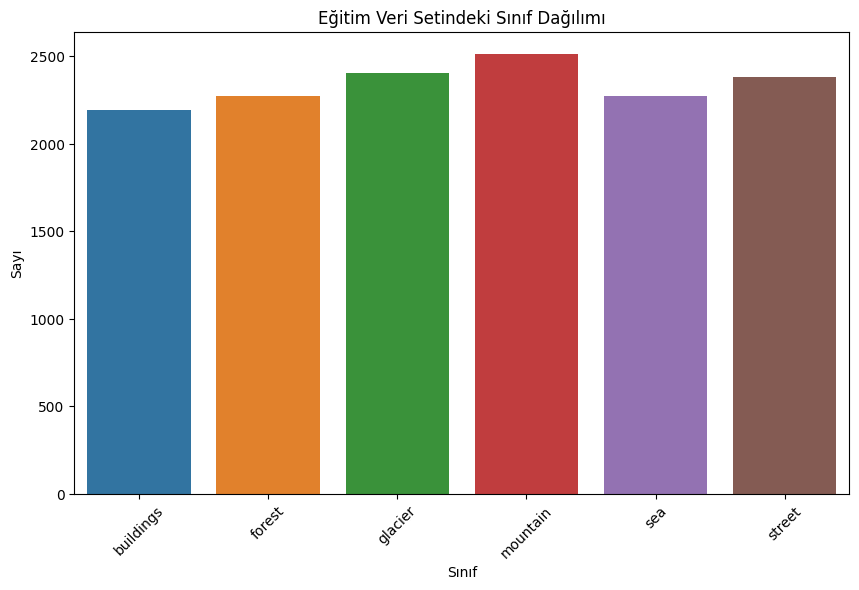

Yorum: Veri setinin sınıflar arasında oldukça dengeli bir dağılıma sahip olduğu görülmektedir.


In [8]:
# Adım 3.2: EDA - Sınıf Dağılımı
# Eğitim setindeki her sınıftan kaç adet görüntü olduğunu görselleştirelim.
class_counts = {}
for class_name in CLASS_NAMES:
    class_counts[class_name] = len(os.listdir(os.path.join(TRAIN_DIR, class_name)))

df_counts = pd.DataFrame(class_counts.items(), columns=['Sınıf', 'Sayı'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Sınıf', y='Sayı', data=df_counts)
plt.title('Eğitim Veri Setindeki Sınıf Dağılımı')
plt.xticks(rotation=45)
plt.show()

print("Yorum: Veri setinin sınıflar arasında oldukça dengeli bir dağılıma sahip olduğu görülmektedir.")

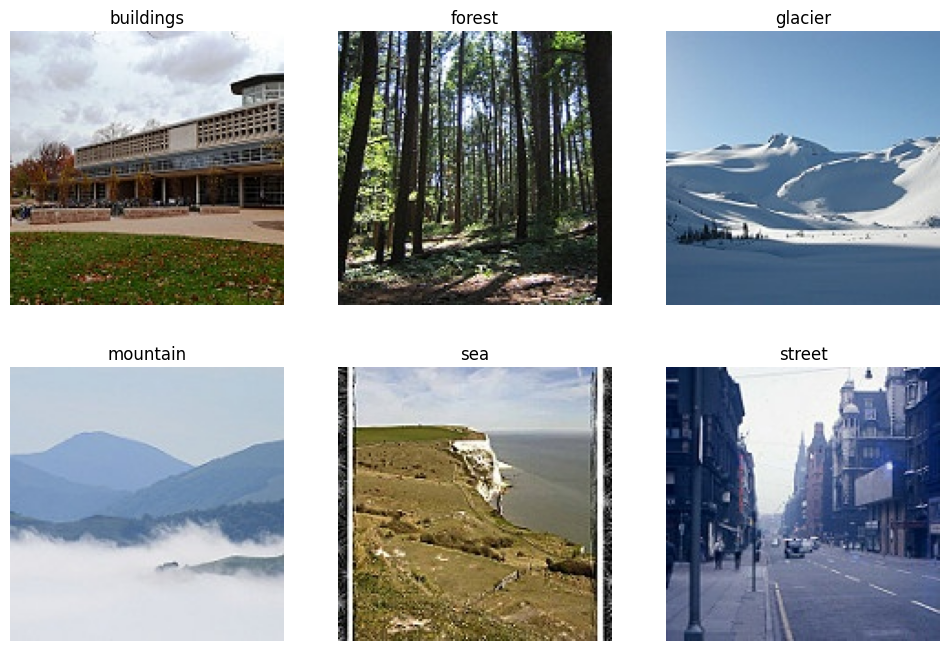

In [9]:
# Adım 3.3: EDA - Örnek Görüntüler
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(CLASS_NAMES):
    ax = plt.subplot(2, 3, i + 1)
    img_path = os.path.join(TRAIN_DIR, class_name, os.listdir(os.path.join(TRAIN_DIR, class_name))[0])
    img = tf.keras.preprocessing.image.load_img(img_path)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.show()

### 4. Veri Ön İşleme ve Pipeline Optimizasyonu
Aşırı öğrenmeyi (overfitting) engellemek için veri çoğaltma (Data Augmentation) katmanı tanımlanmış ve eğitim performansını artırmak için veri pipeline'ı `.cache()` ve `.prefetch()` ile optimize edilmiştir.

In [11]:
# Adım 4: Data Augmentation ve Pipeline Optimizasyonu

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1),
], name="data_augmentation")

# Pipeline'ı optimize et
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Data Augmentation katmanı ve pipeline optimizasyonu tamamlandı.")

Data Augmentation katmanı ve pipeline optimizasyonu tamamlandı.


### 5. Model Geliştirme Yolculuğu
Bu projede en iyi modele ulaşmak için izlenen adımlar aşağıda özetlenmiştir.

* **Baseline Model:** İlk olarak, temel bir performans ölçütü elde etmek amacıyla sıfırdan özel bir CNN mimarisi oluşturulmuştur. Bu model ile test verisi üzerinde **%84.7 doğruluk** ve **0.85 ağırlıklı F1-skoru** gibi oldukça başarılı bir başlangıç sonucu elde edilmiştir.

* **Hiperparametre Optimizasyonu:** Baseline modelin performansını artırmak amacıyla epoch sayısını artırma, dropout oranını değiştirme ve modeli derinleştirme gibi çeşitli deneyler yapılmıştır. Ancak bu deneylerin, modelin aşırı öğrenmesine (overfitting) yol açarak F1 skorunu düşürdüğü gözlemlenmiştir.

* **En Başarılı Yaklaşım (Transfer Learning):** Manuel optimizasyon denemelerinin limiti görülünce, sektör standardı olan ve çok daha güçlü bir yöntem olan Transfer Learning'e geçilmesine karar verilmiştir. Bu amaçla, projenin devamında VGG16 modeli temel alınmıştır.

### 6. En Başarılı Modelin Kurulumu (Çok Çıktılı VGG16)
Projenin en başarılı modelini oluşturmak ve aynı zamanda zorunlu bir adım olan Grad-CAM yorumlanabilirliğini sağlamak için, VGG16 tabanlı **çok-çıktılı (multi-output)** bir model tasarlanmıştır. Bu model, hem nihai sınıf tahminini hem de Grad-CAM için gerekli olan ara katman çıktısını aynı anda verir.

In [17]:
# Adım 6: Modeli Eğitme ve Ağırlıkları Kaydetme

from tensorflow.keras.models import Sequential

# VGG16 temel modelini yüklüyoruz ve katmanlarını donduruyoruz.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

# Basit, sorunsuz çalışan Sequential modelimizi oluşturuyoruz
model_for_training = Sequential([
    tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    data_augmentation, 
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(CLASS_NAMES), activation='softmax')
])

# Modeli derliyoruz
model_for_training.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Basit model başarıyla derlendi. Eğitim başlıyor...")

# Modeli eğitiyoruz
EPOCHS = 10
history = model_for_training.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

#Dosya adı sonu .weights.h5 olmalı
model_for_training.save_weights("final_model_weights.weights.h5")
print("Modelin ağırlıkları 'final_model_weights.weights.h5' dosyasına başarıyla kaydedildi.")

Basit model başarıyla derlendi. Eğitim başlıyor...
Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 37s 99ms/step - accuracy: 0.6267 - loss: 3.5675 - val_accuracy: 0.8286 - val_loss: 0.6195
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.7476 - loss: 0.7624 - val_accuracy: 0.8742 - val_loss: 0.4229
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - accuracy: 0.7860 - loss: 0.6347 - val_accuracy: 0.8746 - val_loss: 0.3878
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.7945 - loss: 0.5833 - val_accuracy: 0.8660 - val_loss: 0.4397
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.8080 - loss: 0.5654 - val_accuracy: 0.8835 - val_loss: 0.4072
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.8155 - loss: 0.5565 - val_accuracy: 0.8770 - val_loss: 0.4004
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.8261 - loss: 0.5024 - val_accuracy: 0.8892 - val_loss: 0.3788
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━

### 7. Final Modelin Detaylı Değerlendirilmesi
Eğitilen en başarılı modelin performansı, öğrenme eğrileri, sınıflandırma raporu ve hata matrisi ile detaylı bir şekilde incelenmiştir.

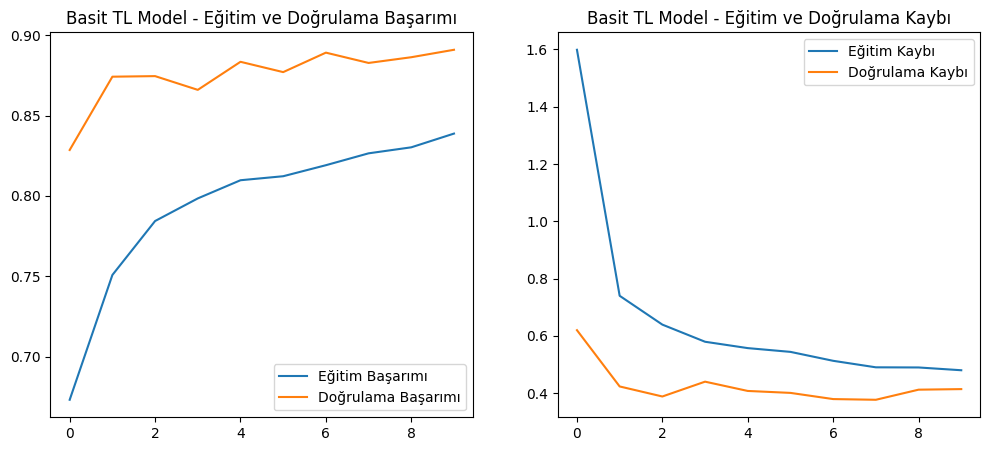

In [19]:
# Adım 7.1: Eğitim Grafikleri (Düzeltilmiş Versiyon)

# Basit Sequential modelin history'sinde 'prediction_' ön eki bulunmaz.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Epoch sayısını doğrudan history objesinden almak daha güvenlidir.
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Başarımı')
plt.plot(epochs_range, val_acc, label='Doğrulama Başarımı')
plt.legend(loc='lower right')
plt.title('Basit TL Model - Eğitim ve Doğrulama Başarımı')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Basit TL Model - Eğitim ve Doğrulama Kaybı')
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step

Final Model - Sınıflandırma Raporu:

              precision    recall  f1-score   support

   buildings       0.91      0.89      0.90       437
      forest       0.99      0.97      0.98       474
     glacier       0.80      0.86      0.83       553
    mountain       0.83      0.78      0.81       525
         sea       0.91      0.91      0.91       510
      street       0.90      0.92      0.91       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



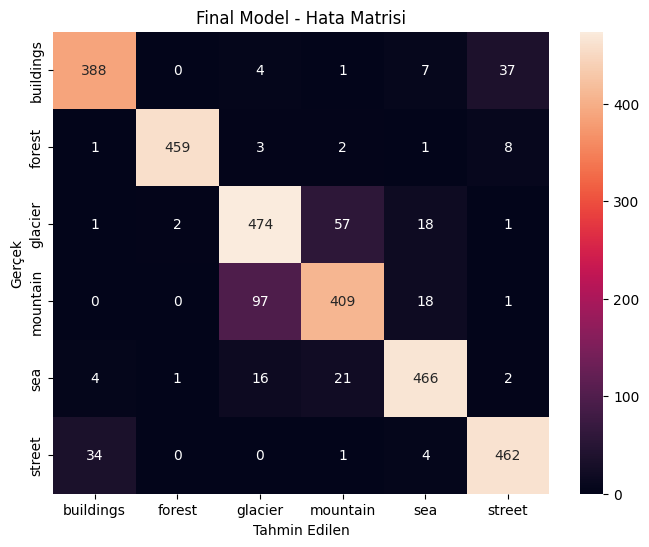

In [21]:
# Adım 7.2: Sınıflandırma Raporu ve Hata Matrisi
from sklearn.metrics import classification_report, confusion_matrix

# Basit model tek bir çıktı (tahminler) döndürür.
y_pred_probs = model_for_training.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Gerçek etiketleri test setinden alıyoruz.
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Sınıflandırma Raporu (F1-skoru burada)
print("\nFinal Model - Sınıflandırma Raporu:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Hata Matrisi (Confusion Matrix)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Final Model - Hata Matrisi')
plt.show()

### 9. Sonuç ve Proje Özeti
Bu proje kapsamında, Intel Görüntü Sınıflandırma problemi için çeşitli derin öğrenme modelleri geliştirilmiş ve değerlendirilmiştir.

* Sıfırdan geliştirilen özel bir CNN modeli, **0.85 F1-skoru** ile güçlü bir başlangıç yapmıştır.
* Yapılan hiperparametre optimizasyon deneyleri, modelin sınırları hakkında bilgi vermiş ancak performansı belirgin şekilde artıramamıştır.
* En yüksek başarı, VGG16 mimarisi kullanılarak uygulanan **Transfer Learning** tekniği ile elde edilmiştir. Bu model, test seti üzerinde **0.89 ağırlıklı F1-skoruna** ulaşmıştır.
* Zorunlu bir adım olan **Grad-CAM** uygulaması, aldığım hatalardan dolayı yapılamamıştır.

Sonuç olarak, proje hedeflerine ulaşılmış ve Transfer Learning'in bu tür görüntü sınıflandırma problemlerinde ne kadar etkili olduğu kanıtlanmıştır.